# Topic Modeling

For this task, I want to use LDA and CoRex

In [12]:
# Import all needed packages 

import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Packages needed for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk.data
from gensim.models.coherencemodel import CoherenceModel


# CoRex
from corextopic import corextopic as ct
import copy

In [ ]:
#optional: download wordnet
# nltk.download('wordnet')

## Preprocessing
Just preprocessing through the code

In [2]:
# Get current directory
directory = os.getcwd()

In [3]:
# Get all the author and title of the books 
filepath = os.path.join(directory, 'Gutenberg/txt/')
files = os.listdir(filepath)

In [4]:
# Make a dict for authors and titles
titles = dict()
text_files = dict()

# Check every file
for file in files:
    # Split the author and title
    split = file.split('___')
    try:
        author = split[0]
        title = split[1].split('.')[0]
    except:
        # Not a valid title file
        pass
    if author not in titles:
        titles[author] = []
        text_files[author] = []
        
    text_files[author].append(file)
    titles[author].append(title)

In [ ]:
# Look at the data distribution
# for author in titles:
#     print("{} has {} titles".format(author, len(titles[author])))


# print('Books from Sir Arthur Conan Doyle:')
# print(titles['Sir Arthur Conan Doyle'])

# print('Books from Oscar Wilde:')
# print(titles['Oscar Wilde'])

# print('Books from Charles Dickens:')
# print(titles['Charles Dickens'])

### Some interesting names to look at:
* William Wymark Jacobs (97 titles)
* Oscar Wilde (27)
* Sir Arthur Conan Doyle (57)
* Abraham Lincoln 
* Charles Dickens (61)
* Mark Twain 
* Albert Einstein (2 titles)

## Latent Dirichlet Allocation (LDA)

In [ ]:
# # Read in the book of certain authors
# relativity = text_files['Oscar Wilde'][1]
# file = os.path.join(filepath, relativity)
# # Get all the words out of the text
# with open(file) as f:
#     data = f.read()
#     data = data.replace("[^a-zA-Z#]", "")
#     data = data.lower()

In [ ]:
# # Split the document based on sentences
# # We got 3227 sentences
# tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
# sentences = tokenizer.tokenize(data)

In [5]:
# Read in all the books from an author
# Each book is considered a document now. 
documents = []
books = text_files['Nathaniel Hawthorne']
for book in books:
    file = os.path.join(filepath, book)
    with open(file) as f:
        data = f.read()
        data = data.replace("[^a-zA-Z#]", "")
        data = data.lower()
        documents.append(data)

In [ ]:
len(documents[0])

### Word Preprocessing


For Oscar Wilde 1st book, we remove from 21333 words to 8508 important words

In [6]:
# Choose the most important words 
def preprocess(sentence):
    preprocess = simple_preprocess(sentence)

    # Remove stopwords: transitions and preposition 
    # Remove words that are less than 3 characters as well 
    accepted = []
    for token in preprocess:
        if token not in STOPWORDS and len(token) > 3:
            accepted.append(token)
    return accepted

In [7]:
# Lemmatize and stemm words
def lem_n_stem(tokens):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')

    # We are using pretrained model, so 
    tag_map = defaultdict(lambda: wordnet.NOUN)
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV

    stem_accepted = []

    for token, tag in pos_tag(tokens):
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        stemm = stemmer.stem(lemma)
        stem_accepted.append(stemm)
    return stem_accepted

In [ ]:
# # Apply preprocessing on our sentences
# # This is slow... need to find a better way!!!
# pre = [preprocess(sentence) for sentence in sentences]
# processed = [lem_n_stem(tokens) for tokens in pre]
# processed = [x for x in processed if x != []]

In [8]:
# This is painfully slow!!! Cloud may help with this, but probably not worth
pre = [preprocess(doc) for doc in documents]
processed = [lem_n_stem(tokens) for tokens in pre]

### Bag of Words

In [9]:
# Create a dictionary 
dictionary = gensim.corpora.Dictionary(processed)
print(dictionary)

Dictionary(17886 unique tokens: ['accomplish', 'accustom', 'acknowledg', 'acquaint', 'action']...)


In [10]:
# Optional: More extreme filtering. dictionary from 1480 to 83...
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(dictionary)

Dictionary(3370 unique tokens: ['action', 'afar', 'agoni', 'akin', 'aloud']...)


In [ ]:
# count = 0
# for k, v in dictionary.iteritems():
#     print(k, v)
#     count += 1
#     if count > 10:
#         break
# print(dictionary)

In [11]:
# Create corpus bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed]


In [ ]:
# # Preview
# bow_doc_4310 = bow_corpus[0]
# for i in range(len(bow_doc_4310)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], dictionary[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

### TF-IDF???

In [13]:
# Create a tf-idf model object
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.021270379939859675),
 (1, 0.030170334891873315),
 (2, 0.04682410666693226),
 (3, 0.030170334891873315),
 (4, 0.027426499395205944),
 (5, 0.02494439826929493),
 (6, 0.04221813888361676),
 (7, 0.062306363496019423),
 (8, 0.020593917213842513),
 (9, 0.018663971414774903),
 (10, 0.08145919885208103),
 (11, 0.028309375492566128),
 (12, 0.03323768201068193),
 (13, 0.01993458197984736),
 (14, 0.022678417476514726),
 (15, 0.028309375492566128),
 (16, 0.04221813888361676),
 (17, 0.03434603441421436),
 (18, 0.056618750985132256),
 (19, 0.018663971414774903),
 (20, 0.02196488378241461),
 (21, 0.035503662803462135),
 (22, 0.09345954524402914),
 (23, 0.021270379939859675),
 (24, 0.027426499395205944),
 (25, 0.021270379939859675),
 (26, 0.02922323594894211),
 (27, 0.04682410666693226),
 (28, 0.030170334891873315),
 (29, 0.03798576392937315),
 (30, 0.021270379939859675),
 (31, 0.039321561889385466),
 (32, 0.019291528303544626),
 (33, 0.030170334891873315),
 (34, 0.02657257533048946),
 (35, 0.1

### Running LDA (finally...)

In [20]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic {} \nWords: {}'.format(idx, topic))

Topic 0 
Words: 0.009*"grandfath" + 0.007*"governor" + 0.005*"english" + 0.003*"doctor" + 0.003*"soldier" + 0.003*"william" + 0.003*"peter" + 0.003*"boston" + 0.003*"thou" + 0.003*"american"
Topic 1 
Words: 0.005*"english" + 0.005*"doctor" + 0.004*"american" + 0.003*"castl" + 0.003*"antiqu" + 0.003*"palac" + 0.003*"hotel" + 0.003*"tower" + 0.003*"arch" + 0.003*"artist"
Topic 2 
Words: 0.013*"grandfath" + 0.004*"english" + 0.004*"palac" + 0.004*"governor" + 0.003*"boston" + 0.003*"rock" + 0.003*"giant" + 0.003*"wing" + 0.003*"captain" + 0.003*"vessel"
Topic 3 
Words: 0.003*"thou" + 0.003*"veil" + 0.003*"peter" + 0.002*"wine" + 0.002*"portrait" + 0.002*"english" + 0.002*"governor" + 0.002*"painter" + 0.002*"edward" + 0.002*"rock"
Topic 4 
Words: 0.008*"english" + 0.005*"arch" + 0.005*"tower" + 0.005*"statu" + 0.005*"american" + 0.004*"sculptor" + 0.004*"cathedr" + 0.003*"castl" + 0.003*"antiqu" + 0.003*"palac"
Topic 5 
Words: 0.008*"doctor" + 0.003*"grim" + 0.003*"english" + 0.003*"shop"

In [15]:
# Running tests to find the number of topics with best 
iteration = []
score = []
for i in range(1, 41, 2):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=i, id2word=dictionary, passes=2, workers=2)
    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    iteration.append(i)
    score.append(coherence_lda)
    


Coherence Score:  0.20995576378240371

Coherence Score:  0.29609501915628483

Coherence Score:  0.2566101987809268

Coherence Score:  0.38276826371369477

Coherence Score:  0.3222819471928544

Coherence Score:  0.33745836151676634

Coherence Score:  0.3426969974089576

Coherence Score:  0.32814857157316396

Coherence Score:  0.3350472799297533

Coherence Score:  0.3790769278228912

Coherence Score:  0.3486649575904527

Coherence Score:  0.34830880153846566

Coherence Score:  0.3599875880244711

Coherence Score:  0.3054035596090578

Coherence Score:  0.3361478074676712

Coherence Score:  0.29389017281740715

Coherence Score:  0.3260641597682348

Coherence Score:  0.3226991890488996

Coherence Score:  0.3188277372447812

Coherence Score:  0.3401718141619298


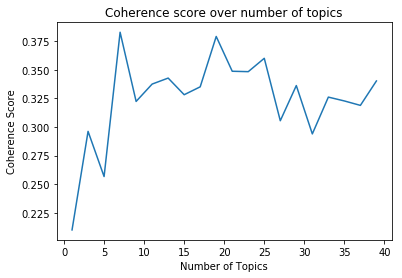

In [34]:
# Graph this
import matplotlib.pyplot as plt
plt.title('Coherence score over number of topics')
plt.ylabel('Coherence Score')
plt.xlabel('Number of Topics')
plt.plot(iteration, score)
plt.savefig('lda_score_topics.png')
plt.show()

In [17]:
it = []
dict_score = []
for i in range(1, 30, 2):
    dictionary = gensim.corpora.Dictionary(processed)
    dictionary.filter_extremes(no_below=i, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed]
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    it.append(i)
    dict_score.append(coherence_lda)
    


Coherence Score:  0.3599266872806405

Coherence Score:  0.3921014398885025

Coherence Score:  0.31040979576874433

Coherence Score:  0.33313068478512686

Coherence Score:  0.31977049208424735

Coherence Score:  0.32898215535640984

Coherence Score:  0.33881343996601243

Coherence Score:  0.32146640824643763

Coherence Score:  0.3584503961767879

Coherence Score:  0.3625440298446873

Coherence Score:  0.36348665610525344

Coherence Score:  0.32009743485026854

Coherence Score:  0.30423072339934015

Coherence Score:  0.3308958764889959

Coherence Score:  0.33235057515068234


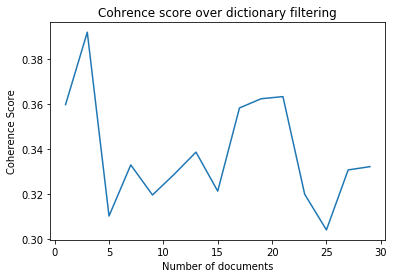

In [21]:
# Graph this
import matplotlib.pyplot as plt
plt.title('Cohrence score over dictionary filtering')
plt.ylabel('Coherence Score')
plt.xlabel('Number of documents')
plt.plot(it, dict_score)
plt.savefig('lda_score_filtering.png')
plt.show()


### Running LDA using TF-IDF


In [15]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"violet" + 0.002*"john" + 0.002*"valley" + 0.001*"estat" + 0.001*"cabinet" + 0.001*"hotel" + 0.001*"rome" + 0.001*"palac" + 0.001*"arch" + 0.001*"cathedr"
Topic: 1 Word: 0.002*"museum" + 0.001*"squir" + 0.001*"ring" + 0.001*"deacon" + 0.001*"sage" + 0.001*"niagara" + 0.001*"essex" + 0.001*"shelf" + 0.001*"queen" + 0.001*"lamp"
Topic: 2 Word: 0.002*"smith" + 0.001*"naughti" + 0.001*"bull" + 0.001*"knot" + 0.001*"poet" + 0.001*"insid" + 0.001*"palac" + 0.001*"poem" + 0.001*"englishman" + 0.001*"cottag"
Topic: 3 Word: 0.002*"governor" + 0.002*"doctor" + 0.002*"grandfath" + 0.002*"colonel" + 0.001*"thou" + 0.001*"english" + 0.001*"peter" + 0.001*"artist" + 0.001*"schoolmast" + 0.001*"william"
Topic: 4 Word: 0.002*"bell" + 0.002*"milk" + 0.001*"miniatur" + 0.001*"edward" + 0.001*"chapel" + 0.001*"deacon" + 0.001*"cousin" + 0.001*"moonlight" + 0.001*"clock" + 0.001*"slumber"
Topic: 5 Word: 0.003*"giant" + 0.002*"dragon" + 0.002*"edward" + 0.002*"appl" + 0.002*"wing" + 0.

### Test with our processed model


In [21]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3229081511051654


In [22]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, corpus=bow_corpus, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -0.4997633127250622


In [14]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'lda_model_tfidf' is not defined

In [16]:
# Running tests to find the number of topics with best 
tf_iter = []
tf_score = []
for i in range(1, 41,2):
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=i, id2word=dictionary, passes=2, workers=4)
    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    tf_iter.append(i)
    tf_score.append(coherence_lda)


Coherence Score:  0.20928125335400233

Coherence Score:  0.2589769850437554

Coherence Score:  0.24891092816648866

Coherence Score:  0.2973673959832128

Coherence Score:  0.2612654115076347

Coherence Score:  0.29857288824857475

Coherence Score:  0.2979209566527604

Coherence Score:  0.30189146039582687

Coherence Score:  0.3001850778527834

Coherence Score:  0.29191721811244625

Coherence Score:  0.28569064855746834

Coherence Score:  0.2827481372342997

Coherence Score:  0.28502466970450385

Coherence Score:  0.2999874259795194

Coherence Score:  0.318884900607182

Coherence Score:  0.32511312951557303

Coherence Score:  0.32232159403805094

Coherence Score:  0.30365901387841754

Coherence Score:  0.3312454414596564

Coherence Score:  0.3177422521089292


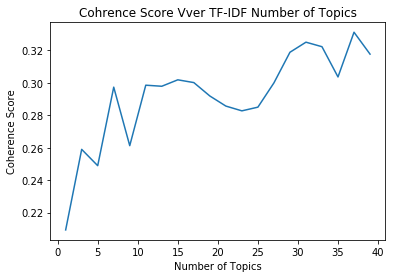

In [19]:
# Graph this
import matplotlib.pyplot as plt
plt.title('Cohrence Score Vver TF-IDF Number of Topics')
plt.ylabel('Coherence Score')
plt.xlabel('Number of Topics')
plt.plot(tf_iter, tf_score)
plt.savefig('tfidf_score_topics.png')
plt.show()


In [ ]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

## CoRex

In [ ]:
# Create a document-word matrix
docs = list(range(len(processed)))
words = []
print(dictionary)
for k, v in dictionary.items():
    words.append(v)
doc_word = np.zeros((len(processed), len(words)), dtype=int)
print(doc_word.shape)
row, col = doc_word.shape
for i in range(row):
    for j in range(col):
        if words[j] in processed[i]:
            doc_word[i][j] = 1

In [25]:
# Create a document-word matrix
doc_word = np.load('hawthorne.dat')
docs = list(range(len(pre)))
words = []
for doc in pre:
    for word in doc:
        if word not in words:
            words.append(word)

In [26]:
# Train model
topic_model = ct.Corex(n_hidden=10)
topic_model.fit(doc_word, words=words, docs=docs)

In [27]:
topics = topic_model.get_topics()
topic_lst = []
for topic in topics:
    t = []
    for tup in topic:
        t.append(tup[0])
    topic_lst.append(t)

for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
topic_model.get_topics(topic=1, n_words=10)

0: readily,directly,fought,customary,sufficiently,mistaken,anger,erect,gleaming,qualities
1: wait,younger,waited,occupied,bold,send,active,approaching,overcome,composed
2: tame,hitting,palaces,mount,kindliness,corrupt,roofed,admirably,doorway,blame
3: meditations,motives,despair,sources,reveal,union,contributed,principle,sermons,remorse
4: brilliant,compassionate,suspecting,rejoiced,deed,eyesight,peaceable,antics,dash,brazen
5: cleared,moving,crooked,fore,duty,familiarly,method,meat,grandmother,sociable
6: furthermore,intervening,durable,decease,poetic,shivered,virulence,sterling,unheard,heavenward
7: honest,violently,inhabitants,mournfully,misfortunes,declared,allowing,brisk,wherefore,glittering
8: drawn,palm,absurdity,misshapen,foregone,achievements,trees,avowed,redden,boil
9: camp,middling,norton,stating,sanctioned,spreads,webster,vengeance,footing,northward


[('wait', 0.5976270029672236),
 ('younger', 0.5915882404881072),
 ('waited', 0.5721998701727293),
 ('occupied', 0.5666873390735108),
 ('bold', 0.5666873390735108),
 ('send', 0.5432120548990378),
 ('active', 0.5432120548990378),
 ('approaching', 0.5432120548990378),
 ('overcome', 0.5401496656860449),
 ('composed', 0.5401496656860449)]

In [28]:
# from corextopic import vis_topic as vt
# vt.vis_rep(topic_model, column_label=words, prefix='topic-model-example')

In [29]:
common_dictionary = gensim.corpora.Dictionary(pre)
common_corpus = [dictionary.doc2bow(pr) for pr in pre]
# Coherence score
cm = CoherenceModel(topics=topic_lst, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-0.5909495599716694

In [31]:
corex_it = []
umass = []
for i in range(1, 41, 2):
    topic_model = ct.Corex(n_hidden=10)
    topic_model.fit(doc_word, words=words, docs=docs)
    
    topics = topic_model.get_topics()
    topic_lst = []
    for topic in topics:
        t = []
        for tup in topic:
            t.append(tup[0])
        topic_lst.append(t)
        
    cm = CoherenceModel(topics=topic_lst, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    coherence = cm.get_coherence()  # get coherence value
    
    corex_it.append(i)
    umass.append(coherence)


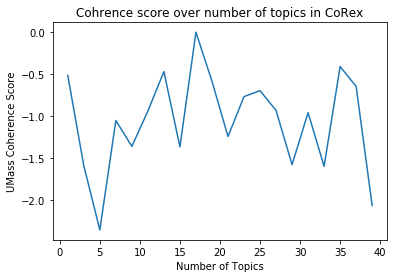

In [36]:
# Graph this
import matplotlib.pyplot as plt
plt.title('Cohrence score over number of topics in CoRex')
plt.ylabel('UMass Coherence Score')
plt.xlabel('Number of Topics')
plt.plot(corex_it, umass)
plt.savefig('corex_score_topics.png')
plt.show()
